Suppose a casino offers a variation of craps that costs $1 to play and pays out $4 when the same number is rolled on two 6 sided dice.
The theoretical probability of winning $4 is 6 in 36, and the theoretical probability of losing $1 is 30 in 36. What do we expect to have at the end of the day after 150 rounds? Or at the end of the week after 1000 rounds? Rather than averaging, we can explore the probability space by simulating the gameplay using a Monte Carlo Simulation.


This is an advantageous thing to try because of what we eventually want to show:
-There are interesting features in the data, like global maxes and mins
-That there's spread in the final results that the theoretical probability doesn't catch
-That the probability of profiting in the end is not great (and provide a C.I.)

In a complicated case where the theoretical probability cannot be known, Monte Carlo simulations can help us make a prediction with data.

Let us define our win condition as the sum of a roll of 2 6 sided dice being equal to 7 or 11.
Let the losing condition be 
Let all other outcomes be a stalemate.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
import math



def dice_roll_outcome():
    die1 = random.randint(1,6)
    die2 = random.randint(1,6)
    sum = die1 + die2

    if sum in [7,11]:
        return "Win"
        # P(Win) = (6+2)/36 = 8/36 = 2/9
    elif sum in [2,3,12]:
        return "Lose"
        # P(2)UP(3)UP(12) =(1+2+1)/36 = 1/9
    else:
        if random.randint(1,6) == 1:
            return "Lose"
            # P(Lose) = 1/9 + (1/6)*(1-(3/9)) = 
        return "Stale"
        #P(Stale) = (5/6)*(1-(3/9))


def dice_roll_outcome_2():
    die1 = random.randint(1,6)
    die2 = random.randint(1,6)

    if die1 == die2:
        return "Win"
    else:
        return "Lose"

In [4]:
# Let's define our inputs
#actual_win_probability = (36-30)/36
actual_win_probability = (6+2)/36

num_simulations = 100
max_num_rolls = 500
bet = 1
win_amount = 40
lose_amount = -40
starting_balance = 1000

This Monte Carlo simulation will be simulating a _random walk_ in 1 dimension - a statistical experiment where on each step, there is some p chance of moving a in the +x direction, and some 1-p chance of moving b in the -x direction. In this case, there is a p chance of earning money, a q chance of losing money, and a 1-(p+q) chance of a stalemate in which the player'smoney stays the same. (trivia q: Is this realistic to how real games of craps are played?)

In [5]:
results = pd.DataFrame([])
wins = 0
end_balance = []

for i in np.arange(num_simulations):
    balance = {0: starting_balance}

    for roll in np.arange(max_num_rolls):
        win = dice_roll_outcome()
        if win == "Win":
            balance[roll+1] = balance[roll] + win_amount
            wins += 1
        elif win == "Stale":
            balance[roll+1] = balance[roll]
        else:
            balance[roll+1] = balance[roll] + lose_amount

    end_balance.append(balance[max_num_rolls])
    balance = pd.Series(balance, name = i+1)
    results = pd.concat([results, balance], axis = 1)


win_probability = wins/(max_num_rolls * num_simulations)
std = results.loc[max_num_rolls].std(axis = 0)
conf_int = std*(1.96/(math.sqrt(num_simulations)))
average = results.loc[max_num_rolls].sum(axis = 0)/num_simulations
#plt.plot(max_num_rolls, balance)

This figure will show us the results of every run with no commentary.

[]

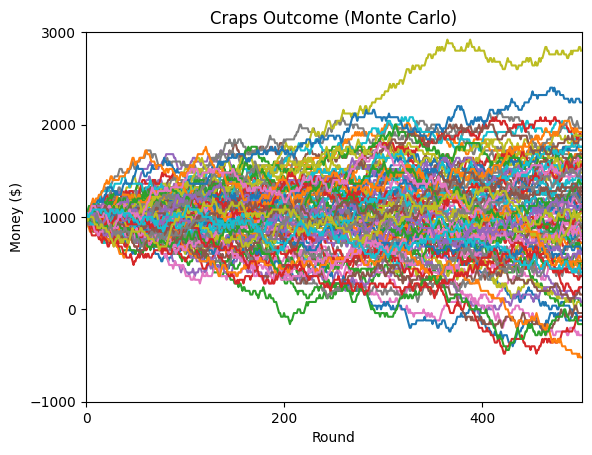

In [6]:
ymin = -1000
ymax = 3000 + 1
ystep = 1000
xmin = 0
xmax = max_num_rolls + 1
xstep = 200

results.plot.line(xlim = (xmin, xmax), xticks = np.arange(xmin, xmax, xstep), 
ylim = (ymin, ymax), yticks = np.arange(ymin, ymax, ystep), 
title = "Craps Outcome (Monte Carlo)", xlabel = "Round", ylabel = "Money ($)", legend = False)
plt.plot()

In [ ]:
results.loc[max_num_rolls]

1      1000
2       -40
3       640
4       640
5      1200
       ... 
196    1360
197     120
198     960
199    1160
200     880
Name: 500, Length: 200, dtype: int64

In [ ]:
print(f"After a game of {max_num_rolls} rounds, the number of wins expected is {round(max_num_rolls * win_probability)}, for a probability of \n"
f"    {round(win_probability * 100, 3)}% to win versus a theoretical probability of {round(actual_win_probability*100, 3)}%.")
print(f"The mean final balance across {num_simulations} simulations was ${round(average, 2)}, with a standard deviation of ${round(std, 2)}.")
print(f"The 95% confidence interval of the final balance was ${round((average - conf_int), 2)} to ${round((average + conf_int), 2)}.")
print(f"The highest balance ever recorded across all trials was ${results.max().max()}, and the lowest was ${results.min().min()}.")
print(f"The highest balance at the end of the game was ${results.loc[max_num_rolls].max()}, and the lowest was ${results.loc[max_num_rolls].min()}.")
final = results.loc[max_num_rolls]
print(f"The probability, after {max_num_rolls} rounds, of a simulation finishing with more money than it started with was {round(100*(final[final > 1000].count())/num_simulations, 3)}%.")

After a game of 500 rounds, the number of wins expected is 112, for a probability of 
    22.491% to win versus a theoretical probability of 22.222%.
The mean final balance across 200 simulations was $1126.2, with a standard deviation of $588.18.
The 95% confidence interval of the final balance was $1044.68 to $1207.72.
The highest balance ever recorded across all trials was $2640, and the lowest was $-560.
The highest balance at the end of the game was $2600, and the lowest was $-360.
The probability, after 500 rounds, of a simulation finishing with more money than it started with was 55.5%.


In [ ]:
results2 = results
indexes = np.arange(max_num_rolls + 1)
x = pd.DataFrame(indexes)
results2 = pd.concat([x, results2], axis = 1)
results_graph = pd.melt(results2, id_vars = 0, value_vars = list(np.arange(1, num_simulations + 1)))
results_graph = results_graph.rename(columns = {0:"Round"})

This figure will show the averages at every step with confidence intervals to show us the magnitude of the data spread and how it changes over time if at all.

In [ ]:
results_avg = results.mean(axis = 1)
results_CI = results.std(axis = 1)
#results_avg
#print(1.96*(results_CI/(math.sqrt(num_simulations))))
avgs = pd.DataFrame({"steps": np.arange(max_num_rolls+1),
'averages': results_avg})

In [ ]:
gdata = results_graph[results_graph.Round % 50 == 0]
gdata

,Round,variable,value
0,0,1,1000
50,50,1,995
100,100,1,1000
150,150,1,965
200,200,1,960
...,...,...,...
399999,1800,200,550
400049,1850,200,545
400099,1900,200,535
400149,1950,200,525


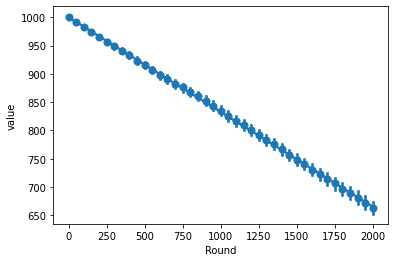

In [ ]:
#sns.set(font_scale=1.5,style="white")
sns.regplot(x='Round', y='value', data=gdata, x_estimator = np.mean, x_ci = 95)
plt.show()